In [1]:
import sys
sys.path.append('..')

In [2]:
from importlib import reload
from os.path import exists

import networkx as nx
import numpy as np
import pandas as pd
import lib.obo
import lib.classification.elastic
import lib.classification.validation
import lib.utils
import data
import pymonad

reload(lib.classification.validation)
reload(lib.classification.elastic)
reload(lib.obo)
reload(lib.utils)
reload(data)

from lib.classification.elastic import annotate_index, collapse_matches, build_synonyms_graph
from lib.utils import map_series, expand_dataframe, expand, flatten
from lib.classification.validation import correct_ratio, incorrect_ratio, perfect_match
from geo_annotation.import_ontology_es import import_ontology
from elasticsearch import Elasticsearch
from lib.obo import read_ontology, Ontology
pd.set_option('display.width', 512)

In [3]:
import seaborn
%matplotlib inline

In [4]:
larisa_series = data.larisa_series()

larisa_ids = list(map(int, larisa_series.index.unique()))
larisa_vd = pd.DataFrame(dict(classes=larisa_series[['doid']]
                         .reset_index()
                         .groupby('id')['doid']
                         .apply(lambda x: list(set(x)))))
larisa_vd[:7]

AttributeError: 'module' object has no attribute 'larisa_series'

In [443]:
es = Elasticsearch()
ontology = read_ontology('../data/geo-annotation/doid-patched.obo',
                         exclude_duplicates=True)

Read obo graph
Name: 
Type: DiGraph
Number of nodes: 6595
Number of edges: 6594
Average in degree:   0.9998
Average out degree:   0.9998


In [7]:
# Убираем синонимы состоящие только из коротких слов  (len <= 2 )
# (вообще ошибка происходит изза стоп-слов в Elasticsearch, но так проще)

def cell():
    import re
    def tokenize(s):
        return re.split(r'[^\w\d]+', s)
    
    def all_short(synonym):
        return all(len(t) <= 2 for t in tokenize(synonym))
    
    for item_id, item in ontology.meta.items():
        item.synonyms = [s for s in item.synonyms if not all_short(s)]

cell()

In [16]:
import_ontology(ontology, 'disease_ontology')
syn_ontology = Ontology(build_synonyms_graph(ontology, es, 'disease_ontology'), list(ontology.items()))

In [437]:
import pymongo
db = pymongo.MongoClient().scraper_meta
series_ids = [int(d['accession'][3:]) for d in db.series.find({'organism': 'Homo sapiens'}, {'_id': 0, 'accession': 1})]

In [439]:
series_ids[:10]

[43950, 7547, 7563, 7606, 43860, 43862, 43876, 43878, 43880, 43881]

In [450]:
annotation_result_file = '../data/geo-annotation/series.disease.res4.pickle'
if not exists(annotation_result_file):
    res = annotate_index(client=es,
                         ontology=ontology,
                         index='series',
                         ids=larisa_ids
                        )

    res.to_pickle(annotation_result_file)

else:
    res = pd.read_pickle(annotation_result_file)

In [451]:
len(res)

324

In [18]:
def doid_id(item_id):
    return "DOID:{:07}".format(item_id)


def ontology_name(item_id):
    if item_id not in ontology.meta:
        return item_id
    return ontology.meta[item_id].name


def to_name(series_id):
    return "GSE{}".format(series_id)

def name(item_id):
    return '{} ({})'.format(ontology_name(item_id), item_id)

def names(df):
    return df.applymap(lambda xs: [name(x) for x in xs])

def sub_ontology(nodes, ontology):
    subset = set(flatten([nx.shortest_path(ontology.graph, 'DOID:4', cls) for cls in nodes]))
    for n in nodes:
        subset.add(n)
    return nx.subgraph(ontology.graph, subset)

def matches_graph(matches, vd_classes=None, figsize=None, prog='neato'):
    matches = [m for m in matches if m in ontology.graph.nodes()]
    vd_classes = vd_classes or []
    import matplotlib.pyplot as plt
    figsize = figsize or (14, 10)
    plt.figure(figsize=figsize) 
    import networkx as nx
    
    G = sub_ontology(matches + vd_classes, ontology)
    pos=nx.pygraphviz_layout(G, prog=prog) 
    
    labels = dict((k, v) for (k, v) in names_dict.items() if k in G.nodes())
    nodes_other = [x for x in G.nodes() if x not in matches]
    
    nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='r',
             alpha=0.5,
            nodelist=matches)
    
    nx.draw_networkx(G, labels=labels, 
        pos=pos, 
        node_size=400,
        node_color='w',
         alpha=0.8,
        nodelist=nodes_other)
    
    if vd_classes:
        nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='g',
            alpha=0.5,
#             font_color='g',                     
            nodelist=vd_classes)
        
    plt.show()

    
names_dict = dict((record.id, record.name) for record in ontology.meta.values())

In [375]:
cell_type_cancer = 'DOID:0050687'
organ_system_cancer = 'DOID:0050686'
cell_type_benign_neoplasm = 'DOID:0060084'
organ_system_benign_neoplasm = 'DOID:0060085'

@pymonad.curry
def exclude_similar_branches(ontology, classes):
    has_osc = any(ontology.has_path(organ_system_cancer, c) for c in classes)
    if has_osc:
        return [c for c in classes if not ontology.has_path(cell_type_cancer, c) 
#                                       and not ontology.has_path(cell_type_benign_neoplasm, c)
#                                       and not ontology.has_path(organ_system_benign_neoplasm, c) 
               ]
    else:
        return classes

In [390]:
root_disease = 'DOID:4'

@pymonad.curry
def exclude_wide_terms(ontology, classes):
    threshold = 4
    
    return [c for c in classes 
            if len(nx.shortest_path(ontology.graph, root_disease, c)) > threshold]

In [452]:
results = pd.DataFrame(dict(
        odinary=res.classes,
        collapsed=res.classes.map(exclude_wide_terms(ontology) *
                                  collapse_matches(ontology.graph)),
        collapsed_ex=res.classes.map(exclude_wide_terms(ontology) * 
                                     exclude_similar_branches(ontology) *
                                     collapse_matches(ontology.graph)),
#         collapsed_syn=res.classes.map(collapse_matches(syn_ontology.graph) *
#                                      exclude_wide_terms(ontology) * 
#                                      exclude_similar_branches(ontology) *
#                                      collapse_matches(ontology.graph)),
        larisa=larisa_vd.classes,
    )
).applymap(lambda x: [] if isinstance(x, float) else x)

In [89]:
?pd.DataFrame.hist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111c094a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112047f28>]], dtype=object)

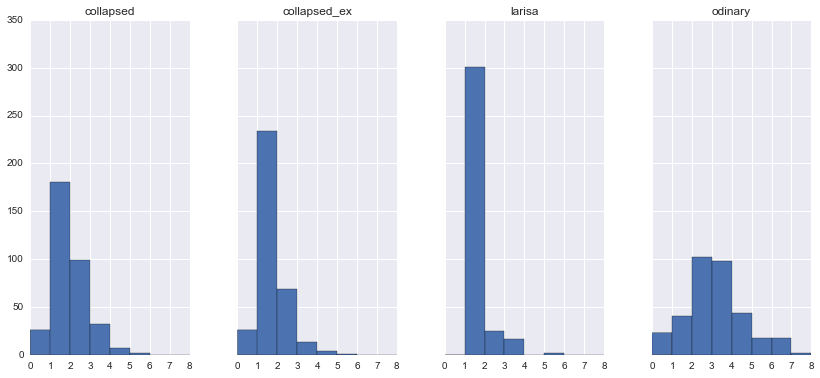

In [453]:
(
    results
    .applymap(len).hist(bins=range(0, 9), 
                        sharey=True, 
                        layout=(1, 4),
                        figsize=(14, 6))
 )

In [431]:
i = 6

6
larisa                        [DOID:0050865]
collapsed_ex    [DOID:0050865, DOID:0050866]
Name: 9844, dtype: object


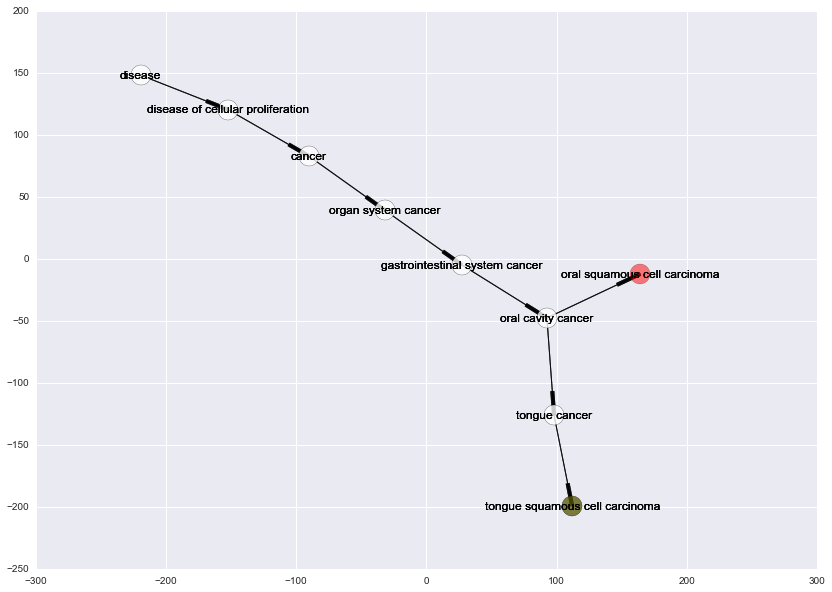

In [432]:
def cell():
    global i
    row = two_classes.iloc[i]
    print(i)
    print(row)
    i += 1
    matches_graph(row.collapsed_ex, row.larisa)
    
cell()

In [393]:
results = results[results.larisa.map(lambda cls: 'DOID:9675/DOID:3770' not in cls)]

In [411]:
def compare(rc, vc):
    return ontology.has_path(rc, vc)

def compare2(rc, vc):
    return ontology.has_path(rc, vc) or ontology.has_path(vc, rc)

def compare3(rc, vc):
    threshold = 4
    if rc == vc:
        return True
    return ontology.has_path(rc, vc) and (nx.shortest_path_length(ontology.graph, rc, vc) <= threshold)
                                
def compare4(rc, vc):
    if rc == vc:
        return True
    return compare3(rc, vc) or compare3(vc, rc)



@pymonad.curry
def cr(vd, res):
    return correct_ratio(res, vd, compare_func=compare4)

@pymonad.curry
def ir(vd, res):
    return incorrect_ratio(res, vd, compare_func=compare4)


@pymonad.curry
def pm(vd, res):
    return perfect_match(res, vd, compare_func=compare4)


def cell():
    global results
    correct = pd.DataFrame(data=dict([(c, cr(results.larisa, results[c])) for c in results.columns if c != 'larisa']))
    incorrect = pd.DataFrame(data=dict([(c, ir(results.larisa, results[c])) for c in results.columns if c != 'larisa']))
    perfect = pd.DataFrame(data=dict([(c, pm(results.larisa, results[c])) for c in results.columns if c != 'larisa']))
    return correct, incorrect, perfect
    
correct, incorrect, perfect = cell()

In [412]:
correct.mean()

collapsed        0.826301
collapsed_ex     0.819075
collapsed_syn    0.816185
odinary          0.843064
dtype: float64

In [413]:
incorrect.mean()

collapsed        0.328565
collapsed_ex     0.254721
collapsed_syn    0.238343
odinary          0.417047
dtype: float64

In [414]:
perfect.mean()

collapsed        0.803468
collapsed_ex     0.794798
collapsed_syn    0.791908
odinary          0.367052
dtype: float64

In [417]:
results.applymap(len).apply(lambda x: x.value_counts())

,collapsed,collapsed_ex,collapsed_syn,larisa,odinary
0,26,26,26,NaN,23
1,181,234,247,300,41
2,98,68,58,25,102
3,32,13,10,17,97
4,7,4,4,NaN,44
5,2,1,1,2,18
6,NaN,NaN,NaN,NaN,18
7,NaN,NaN,NaN,NaN,2
9,NaN,NaN,NaN,1,NaN
10,NaN,NaN,NaN,1,NaN


In [366]:
correct.loc[results[results.larisa.map(lambda x: len(x) == 1)].index].mean()

collapsed        0.853333
collapsed_ex     0.840000
collapsed_syn    0.836667
odinary          0.870000
dtype: float64

In [415]:
incorrect.loc[results[results.larisa.map(lambda x: len(x) == 1)].index].mean()

collapsed        0.270611
collapsed_ex     0.190444
collapsed_syn    0.171556
odinary          0.373439
dtype: float64

In [368]:
perfect.loc[results[results.larisa.map(lambda x: len(x) == 1)].index].mean()

collapsed        0.853333
collapsed_ex     0.840000
collapsed_syn    0.836667
odinary          0.306667
dtype: float64

## Сводная таблица

In [430]:
cols = [c for c in results.columns if c != 'larisa']

counts = results.applymap(len).apply(lambda x: x.value_counts()).loc[1]
pd.DataFrame(dict(scores=[perfect.loc[results[results.larisa.map(lambda x: len(x) == 1)].index].mean()[c] for c in cols],
                  counts=counts),
             index=cols).assign(range=lambda x: x['counts']/larisa_vd.shape[0])

,counts,scores,range
collapsed,181,0.850000,0.521614
collapsed_ex,234,0.843333,0.674352
collapsed_syn,247,0.840000,0.711816
odinary,41,0.386667,0.118156


In [244]:
one_perf = perfect[['collapsed_ex']].loc[results[results.collapsed_ex.map(lambda x: len(x) == 1)].index]
one_perf[~one_perf.collapsed_ex][:10]

,collapsed_ex
2817,False
7553,False
8671,False
10245,False
10334,False
10927,False
10971,False
12090,False
12102,False
13787,False


In [271]:
names(results.loc[one_perf[~one_perf.collapsed_ex].index][['collapsed_ex', 'larisa']])

,collapsed_ex,larisa
2817,[malignant glioma (DOID:3070)],[brain glioma (DOID:0060108)]
7553,[melanoma (DOID:1909)],"[basal cell carcinoma (DOID:2513), skin squamo..."
8671,[adenoma (DOID:657)],[colorectal adenoma (DOID:0050860)]
10245,[lung cancer (DOID:1324)],"[lung adenocarcinoma (DOID:3910), lung squamou..."
10334,[aggressive periodontitis (DOID:1474)],[periodontitis (DOID:824)]
10927,[adenoma (DOID:657)],"[adrenal cortical adenoma (DOID:0050891), adre..."
10971,[serous cystadenocarcinoma (DOID:3114)],[fallopian tube serous adenocarcinoma (DOID:55...
12090,[chromophobe adenocarcinoma (DOID:4471)],"[renal oncocytoma (DOID:6245), chromophobe ade..."
12102,[sarcoma (DOID:1115)],[bone ewing's sarcoma (DOID:3368)]
13787,[breast cancer (DOID:1612)],"[breast carcinoma (DOID:3459), her2-receptor p..."


In [ ]:
names(compare).loc[18842].classes_res

In [ ]:
ontology.meta['DOID:0050865'].dict()

In [ ]:
matches_graph(list(expand(larisa_vd.classes).unique()), figsize=(40, 40))

In [ ]:
import qgrid
def cell():
    print(metrics[metrics.correct_ratio == 0].shape)
    return metrics[metrics.correct_ratio == 0]
qgrid.show_grid(cell())

In [ ]:
index = 22

In [ ]:
def cell():
    global index
    m = metrics[metrics.correct_ratio == 0].copy()
    i = m.index[index]
    row = compare.loc[i]
    
    print(index)
    print(m.index[index])
    print(names(compare).loc[i])
    index += 1
    matches_graph(row.classes_res, row.classes_vd, figsize=(14, 9))
    
cell()

In [ ]:
len(nx.descendants(ontology.graph, 'DOID:0050687')) # cell type cancer,
# A cancer that is classified by the type of cell from which it is derived.

In [ ]:
len(nx.descendants(ontology.graph, 'DOID:0050686')) # organ system cancer,
# A cancer that is classified based on the organ it starts in.

In [ ]:
(metrics.incorrect_ratio > 0).hist()

In [ ]:
# Проверка на коротнкие синонимы

In [ ]:
import re
def tokenize(s):
    return re.split(r'[^\w\d]+', s)

In [ ]:
item_tokens = pd.DataFrame.from_records(((item.id, list(set(token for token in tokenize(name) if token))) for item in ontology.items() for name in item.names()),
                                        columns=['id', 'tokens'])
print(item_tokens.shape)
item_tokens[:10]

In [ ]:
item_tokens[item_tokens['tokens'].map(lambda tokens: all(len(t)<= 2 for t in tokens))]

In [ ]:
item_tokens.iloc[5928].tokens

In [ ]:
expand(metrics[metrics.incorrect_ratio>0].join(names(compare)), column_name='classes_res')

In [ ]:
view = pd.DataFrame.from_records(list(res.items()), columns=('id', 'matches'))
view['name'] = view['id'].map(to_name)
view['matches_names'] = view['matches'].map(lambda matches: [ontology_name(m) for m in matches])
view['matches_count'] = view['matches'].map(len)
view.set_index('name', inplace=True)
view[view['matches_count'] > 1]


# Попытаемся построить графы из заматчивших тканей
ids = view.loc['GSE50081']['matches']

view['collapsed_matches'] = view['matches'].map(collapse_matches(ontology.graph))
view['collapsed_matches_count'] = view['collapsed_matches'].map(len)
view['collapsed_matches_names'] = view['collapsed_matches'].map(lambda matches: [ontology_name(m) for m in matches])
# view['collapsed_matches_syns'] = view['collapsed_matches'].map(collapse_matches(synonyms_graph))
# view['collapsed_matches_syns_count'] = view['collapsed_matches_syns'].map(len)
# nx.has_path(synonyms_graph, 'BTO:0000887', 'BTO:0001149')


view.shape[0], view[view.matches_count == 1].shape[0], view[view.collapsed_matches_count == 1].shape[0]
# (289, 107, 149, 166)
# Ок примерно до половины остается с одной тканью, пока все.
view_m1 = view[view.collapsed_matches_count == 1].copy()

vd = larisa_series[['doid', 'series']].copy()
vd = pd.DataFrame(vd.groupby('series').doid.apply(lambda x: list(set(x)))).reset_index()

check_m1 = pd.merge(view_m1, vd.set_index('series'), left_index=True, right_index=True)
check_m1.shape, check_m1[check_m1['collapsed_matches'] == check_m1['doid']].shape

# ((121, 8), (82, 8)) многовато ошибок

check_m1['doid_names'] = check_m1['doid'].map(lambda matches: [ontology_name(m.strip()) for m in matches])

check_m1[check_m1['collapsed_matches'] != check_m1['doid']][
    ['collapsed_matches', 'doid', 'collapsed_matches_names', 'doid_names']]
check_m1.loc['GSE42252']


# id                                               42252
# matches                          [DOID:1793, DOID:162]
# matches_names              [pancreatic cancer, cancer]
# matches_count                                        2
# collapsed_matches                          [DOID:1793]
# collapsed_matches_count                              1
# collapsed_matches_names            [pancreatic cancer]
# doid                                      [DOID:10534]
# doid_names                            [stomach cancer]


# Если открыть GEO то высветится еще gastric cancer, которого нет в DOID
# Скорее всего изза синонимии gaster и stomach,
# однако, в синонимах DOID это не проставлено
def path_length(graph, id1, id2):
    if id1 in graph.nodes() and \
                    id2 in graph.nodes() and \
            nx.has_path(graph, id1, id2):
        return len(nx.shortest_path(graph, id1, id2)) - 1 if id1 != id2 else 0
    else:
        return np.nan


check_m11 = check_m1[check_m1['doid'].map(lambda d: len(d) == 1)].copy()
check_m11['has_path_res_vd'] = map_series(lambda matches, doid: doid[0] in ontology.graph.nodes() and
                                                                ontology.has_path(matches[0], doid[0]),
                                          [check_m11['collapsed_matches'], check_m11['doid']])

check_m11['absolute_match'] = map_series(lambda matches, doid: matches[0] == doid[0],
                                         [check_m11['collapsed_matches'], check_m11['doid']])

check_m11['path_res_vd'] = map_series(lambda m, d: path_length(ontology.graph, m[0], d[0]),
                                      [check_m11['collapsed_matches'], check_m11['doid']])
check_m11[~check_m11['has_path_res_vd']]
check_m11.loc['GSE51725']
# matches                          [DOID:162]
# matches_names                      [cancer]
# matches_count                             1
# collapsed_matches                [DOID:162]
# collapsed_matches_count                   1
# collapsed_matches_names            [cancer]
# doid                           [DOID:10534]
# doid_names                 [stomach cancer]
# has_path_res_vd                        True

# Опять траблы с gastric == stomach
# Наверное надо модифицировать синонимы

# Плюс надо просерить насколько длинный путь от полученного до проверочного

check_m11.loc['GSE51105']
# matches                       [DOID:162, DOID:2394]
# matches_names              [cancer, ovarian cancer]
# matches_count                                     2
# collapsed_matches                       [DOID:2394]
# collapsed_matches_count                           1
# collapsed_matches_names            [ovarian cancer]
# doid                                   [DOID:10534]
# doid_names                         [stomach cancer]
# has_path_res_vd                                True


# check_m11[check_m11.path_res_vd == 3]
#              id     matches matches_names  matches_count collapsed_matches  collapsed_matches_count collapsed_matches_names          doid        doid_names has_path_res_vd absolute_match  path_res_vd
# GSE15459  15459  [DOID:162]      [cancer]              1        [DOID:162]                        1                [cancer]  [DOID:10534]  [stomach cancer]            True          False            3
# GSE19826  19826  [DOID:162]      [cancer]              1        [DOID:162]                        1                [cancer]  [DOID:10534]  [stomach cancer]            True          False            3
# GSE51725  51725  [DOID:162]      [cancer]              1        [DOID:162]                        1                [cancer]  [DOID:10534]  [stomach cancer]            True          False            3
# GSE57303  57303  [DOID:162]      [cancer]              1        [DOID:162]                        1                [cancer]  [DOID:10534]  [stomach cancer]            True          False            3

# Не нашел gastric


check_m11[check_m11.path_res_vd == 0].shape, check_m11.shape
# ((82, 12), (112, 12))
# Очень неплохие результаты - прямых попаданий 82 из 112

check_m11[check_m11.path_res_vd == 4]
#              id                        matches                             matches_names  matches_count collapsed_matches  collapsed_matches_count  collapsed_matches_names         doid          doid_names has_path_res_vd absolute_match  path_res_vd
# GSE21687  21687  [DOID:162, DOID:3093, DOID:4]  [cancer, nervous system cancer, disease]              3       [DOID:3093]                        1  [nervous system cancer]  [DOID:7497]  [brain ependymoma]            True          False            4

# !!! тупо нет в тексте brain ependymoma, есть просто ependymoma

# Идея как еще можно померить точность: размер входящих подболезней в онтологии
# Такая метрика даст приблизительную оценку насколько "обща" проставленная болезнь

# Теперь сделаем анализ всех попаданий